In [1]:
%load_ext autoreload
%autoreload 2
from gn4pions.modules.nn_functions import * 

In [2]:
df = load_data(file_path = "../data/onetrack_multicluster/pion_files_deltaR/*.npy", n_files=100)

100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Dataframe has 1,027,650 events.


/clusterfs/ml4hep/mpettee/miniconda3/envs/nbdev/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/clusterfs/ml4hep/mpettee/miniconda3/envs/nbdev/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


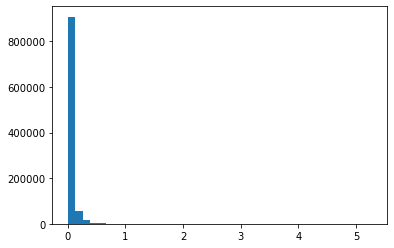

In [3]:
plt.hist(df.delta_r_0, bins=40);

In [4]:
# # recreate EM
# train_vars = ['log10_cluster_e_0',]
# target_var = ['log10_cluster_calib_e_0']

In [5]:
# # recreate track resolution
# train_vars = ['log10_track_pt', 
# #               'track_eta'
#              ]
# target_var = ['log10_truth_particle_pt']

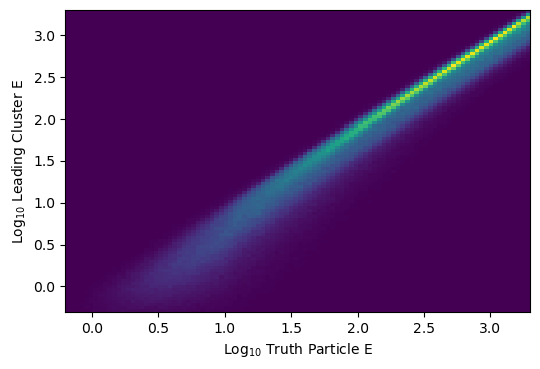

In [35]:
plt.figure(dpi=100)
plt.hist2d(df.log10_truth_particle_e, df.log10_cluster_e_0, bins=100);
plt.xlabel(r'Log$_{10}$ Truth Particle E');
plt.ylabel(r'Log$_{10}$ Leading Cluster E');

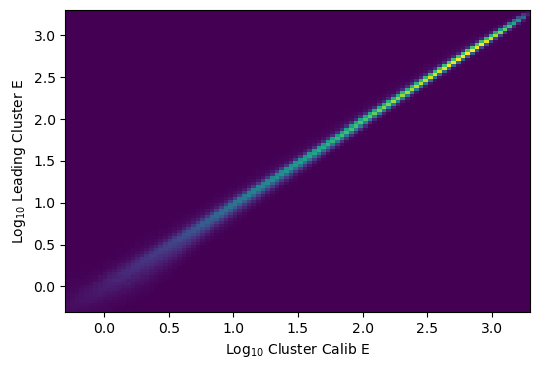

In [40]:
plt.figure(dpi=100)
plt.hist2d(df.log10_cluster_calib_e_0, df.log10_cluster_e_0, bins=100);
plt.xlabel(r'Log$_{10}$ Cluster Calib E');
plt.ylabel(r'Log$_{10}$ Leading Cluster E');

In [36]:
train_vars = [
    'log10_cluster_e_0', 
#     'log10_track_pt',
#     'track_eta'
             ]
# target_var = ['log10_truth_particle_e']
target_var = ['log10_cluster_calib_e_0']

In [37]:
test = train(df, train_vars, target_var, epochs=3)

Epoch 1/3
19725/19725 [==============================] - 44s 2ms/step - loss: 0.0093 - val_loss: 0.0073
Epoch 2/3
19725/19725 [==============================] - 44s 2ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 3/3
19725/19725 [==============================] - 44s 2ms/step - loss: 0.0073 - val_loss: 0.0081


In [38]:
# test[["nn_output", "nn_target"]]

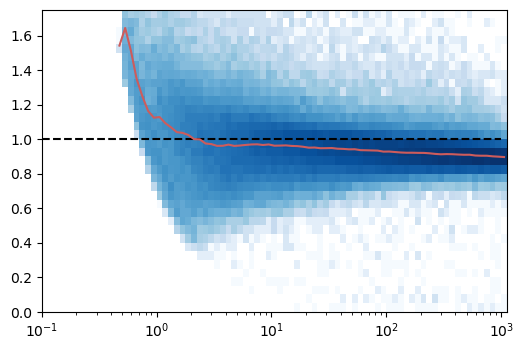

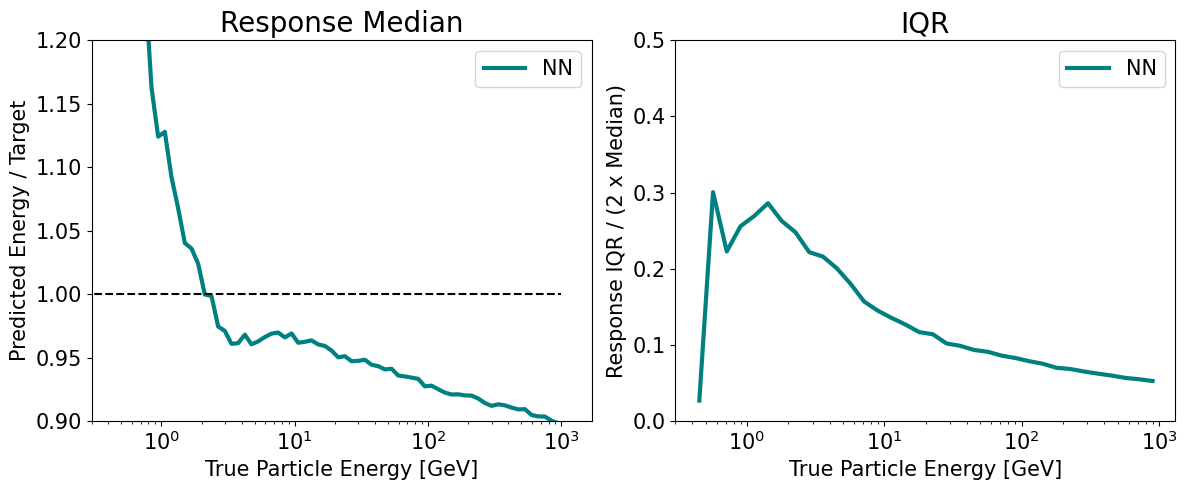

In [39]:
make_plots(test, plot_em=False, plot_track=False, 
#            save_label="dnn"
)